In [1]:
%run "Connect4.py"
# %run "morad.py"
%run "Filip Bots.py"

In [2]:
def cat(board, player, last_move):
    # do the same move as last time, and if that is not possible, do a random move
    if last_move and board[0][last_move] == 0:
        return last_move
    else:
        while True:
            action = random.randint(0, 6)
            if board[0][action] == 0:
                return action

In [3]:
def gravity(board, player, last_move):
    # always fill the lowest column, randomize between the lowest columns if there are multiple
    # first find the lowest columns
    # keep in mind that the board is upside down
    lowest = 0

    for i in range(7):
        for j in range(6):
            if board[j][i] == 0:
                if j > lowest:
                    lowest = j
    lowest_columns = []
    # we know that lowest is the lowest row that is empty

    for i in range(7):
        if board[lowest][i] == 0:
            lowest_columns.append(i)
    return random.choice(lowest_columns)

In [4]:
def gotcha(board, player, last_move):
    # check if a move can be made that will win the game
    # if not, check if a move can be made that will prevent the opponent from winning the game
    # if not, do a random move

    # check if a move can be made that will win the game
    for action in range(7):
        if board[0][action] != 0:
            continue

        board_copy = board.copy()
        for i in range(5, -1, -1):
            if board_copy[i][action] == 0:
                board_copy[i][action] = player
                break
        if check_winner(board_copy) == player:
            return action

    # check if a move can be made that will prevent the opponent from winning the game
    bad_actions = []
    for action in range(7):
        if board[0][action] != 0:
            continue

        board_copy = board.copy()
        for i in range(5, -1, -1):
            if board_copy[i][action] == 0:
                board_copy[i][action] = player
                break

        # now we have played the action on the copy of the board, and check if the opponent can win
        for challenge_action in range(7):
            if board_copy[0][challenge_action] != 0:
                continue

            board_copy2 = board_copy.copy()
            for i in range(5, -1, -1):
                if board_copy2[i][challenge_action] == 0:
                    board_copy2[i][challenge_action] = 3 - player
                    break

            if check_winner(board_copy2) == 3 - player:
                bad_actions.append(action)
                break

    good_actions = []
    for i in range(7):
        if i not in bad_actions and board[0][i] == 0:
            good_actions.append(i)

    if len(good_actions) > 0:
        return random.choice(good_actions)
    else:
        while True:
            action = random.randint(0, 6)
            if board[0][action] == 0:
                return action

In [5]:
@njit
def check_n_in_row(board, n = 3):
    # returns 0 if no winner, 1 if player 1 won, 2 if player 2 won

    # check horizontal
    for i in range(6):
        for j in range(7 - n + 1):
            if board[i][j] != 0:
                for k in range(1, n):
                    if board[i][j] != board[i][j + k]:
                        break
                else:
                    return board[i][j]

    # check vertical
    for i in range(6 - n + 1):
        for j in range(7):
            if board[i][j] != 0:
                for k in range(1, n):
                    if board[i][j] != board[i + k][j]:
                        break
                else:
                    return board[i][j]

    # check diagonal
    for i in range(6 - n + 1):
        for j in range(7 - n + 1):
            if board[i][j] != 0:
                for k in range(1, n):
                    if board[i][j] != board[i + k][j + k]:
                        break
                else:
                    return board[i][j]

    # check other diagonal
    for i in range(6 - n + 1):
        for j in range(n - 1, 7):
            if board[i][j] != 0:
                for k in range(1, n):
                    if board[i][j] != board[i + k][j - k]:
                        break
                else:
                    return board[i][j]

    return 0

@njit
def check_n_in_row_from_position(board,n,x,y):
    # first we make each possible line of length n

    lines = np.zeros((n,n), dtype=np.int64)
    for i in range(n):
        lines[i] = np.arange(n) - n + 1 + i
    player = board[x][y]

    rotations = np.array([[0,1],[1,1],[1,0],[1,-1]])
    for rotation in rotations:
        for line in lines:
            new_line = np.zeros((n,2), dtype=np.int64)
            for i in range(n):
                new_line[i] = line[i] * rotation
            new_line = new_line + np.array([x,y])

            if np.any(new_line < 0):
                continue
            if np.any(new_line[:,0] > 5):
                continue
            if np.any(new_line[:,1] > 6):
                continue

            
            for i in range(n):
                if board[new_line[i][0]][new_line[i][1]] != player:
                    break
            else:
                return player
    return 0


@njit
def treebeard_search(board, player, depth):
    if depth == 0:
        return 0.5 # Todo: add a heuristic here
    
    scores = np.empty(7, dtype=np.float64)  # Pre-allocate a Numpy array for scores
    num_scores = 0
    
    for action in range(7):
        if board[0, action] != 0:
            continue

        # Create a copy of the board using Numpy's copy
        board_copy = board.copy()
        
        for i in range(5, -1, -1):
            if board_copy[i, action] == 0:
                board_copy[i, action] = player
                break
        
        if check_winner(board_copy)==player:
            # print(player,"wins after playing",action,"in depth",depth)
            return 8 * 2**(depth)
        if 0 not in board_copy[0]:
            # print(f"draw after", player, "playing",action,"in depth",depth)
            return 1 * 2**(depth)
        
        scores[num_scores] = -treebeard_search(board_copy, 3 - player, depth - 1)
        num_scores += 1
    
    # Calculate the average of scores and return the negative of it
    if num_scores == 0:
        return 0
    return -np.mean(scores[:num_scores])

def treebeard(board, player, last_move, depth = 5):
    # looks ahead a certain number of moves and then chooses the move that will give the best outcome
    # for each of the 7 possible moves, we look ahead a certain number of moves
    # if we win, we add 2 to the score
    # if we lose, we subtract 2 from the score
    # if we draw, we add -0.5 to the score
    # if there is no winner, we add 0.5
    # overall, we want to maximize the score

    scores = []
    bad_actions = []
    for first_move in range(7):
        if board[0][first_move] != 0:
            scores.append(-10)
            bad_actions += [first_move]
            continue
        board_copy = board.copy()
        for i in range(5, -1, -1):
            if board_copy[i][first_move] == 0:
                board_copy[i][first_move] = player
                break
            
        if check_winner(board_copy) == player:
            return first_move
        
        # now we have played the action on the copy of the board, and check if the opponent can win
        challenger_win = False
        for challenge_move in range(7):
            if board_copy[0][challenge_move] != 0:
                continue

            board_copy2 = board_copy.copy()
            for i in range(5, -1, -1):
                if board_copy2[i][challenge_move] == 0:
                    board_copy2[i][challenge_move] = 3 - player
                    break

            if check_winner(board_copy2) == 3 - player:
                challenger_win = True
                break

        if challenger_win:
            scores.append(-1000)
            # bad_actions += [first_move]
            continue
        scores.append(treebeard_search(board_copy, 3 - player, depth))
    
    # we want to add a small score towards the middle, so it prioritizes the middle when no other moves are better
    for i in range(7):
        scores[i] -= 0.1 * abs(i - 3)

    # check if the opponent can make any moves that will make any 3 in a row
    # any such moves will get an additional +50% of the absolute value of the score so we have a greater incentive to block them

    for challenge_move in range(7):
        if board[0][challenge_move] != 0:
            continue

        board_copy = board.copy()
        for i in range(5, -1, -1):
            if board_copy[i][challenge_move] == 0:
                board_copy[i][challenge_move] = 3 - player
                break
        
        n = 3
        x = challenge_move
        y = i
        
        if check_n_in_row_from_position(board,n,y,x) == 0 and check_n_in_row_from_position(board_copy,n,y,x) == 3 - player:
            scores[challenge_move] += 0.5 * abs(scores[challenge_move])

    for challenge_move in range(7):
        if board[0][challenge_move] != 0:
            continue

        board_copy = board.copy()
        for i in range(5, -1, -1):
            if board_copy[i][challenge_move] == 0:
                board_copy[i][challenge_move] = 3 - player
                break
        
        n = 2
        x = challenge_move
        y = i
        
        if check_n_in_row_from_position(board,n,y,x) == 0 and check_n_in_row_from_position(board_copy,n,y,x) == 3 - player:
            scores[challenge_move] += 0.3 * abs(scores[challenge_move])

    # next we want to negatively weight moves that columns that won't win the game even if we fill them completely
    for move in range(7):
        if board[0][move] != 0:
            continue
        board = board.copy()

        while board[0][move] != 0:
            for i in range(5, -1, -1):
                if board_copy[i][move] == 0:
                    board_copy[i][move] = player
                    break

        if check_winner(board_copy) != player:
            scores[move] -= 0.9 * abs(scores[move])
            
    # sort the indexes 0-6 based on the scores
            
    indexes = np.argsort(scores)
    for i in range(6,-1,-1):
        if board[0][indexes[i]] == 0:
            if len(bad_actions) < 7:
                if indexes[i] in bad_actions:
                    continue
            # print(indexes[i])
            return indexes[i]   


# we need to fix this! It should weight a loss more than the draw
        
# weird: this position gives 0, although it should play 3 to prevent the opponent from winning
board = [[0, 2, 2, 0, 0, 2, 0], [0, 1, 1, 2, 1, 1, 0], [2, 2, 2, 1, 2, 2, 2], [1, 1, 1, 2, 1, 1, 1], [2, 2, 1, 1, 1, 2, 1], [2, 2, 1, 1, 1, 2, 2]] #1
board = np.array(board)
# plot_board(board)
treebeard(board, 1, 0)

0

In [6]:
@njit
def score_row(row):
    # gets an array of length 4 and returns a score
    # if there are +1 and -1, return 0
    # if not, we return the number that's not 0 times 2**n where n is the number of 1s or -1s
    # the array will never have 4 1s or -1s because then the game would be over

    if np.all(row == 0):
        return 0
    
    if np.all(row == 1):
        return 2**5
    
    if np.all(row == -1):
        return -2**5
    
    if 1 in row and -1 in row: 
        return 0
    
    if 1 in row:
        return 2**np.sum(row == 1)
    else:
        return -2**np.sum(row == -1)

@njit
def evaluate_board(board):
    # we find all the rows, columns and diagonals of length 4 and score them using the score_row function

    score = 0
    # first we do the rows
    for i in range(6):
        for j in range(4):
            score += score_row(board[i][j:j+4])

    # then we do the columns
    for i in range(3):
        for j in range(7):
            score += score_row(board[i:i+4,j])

    # then we do the diagonals
    for i in range(3):
        for j in range(4):
            score += score_row(np.diag(board[i:i+4,j:j+4]))

    for i in range(3):
        for j in range(4):
            score += score_row(np.diag(board[i:i+4, j:j+4][::-1, ::-1]))

    return score

In [41]:
@njit
def legal_moves(board):
    # returns a list of all legal moves
    moves = np.empty(0, dtype=np.int64)
    for i in range(7):
        if board[0, i] == 0:
            moves = np.append(moves, i)
    return moves

@njit
def make_move(board, action, player):
    # returns the board after the move has been made
    board_copy = board.copy()
    for i in range(5, -1, -1):
        if board_copy[i, action] == 0:
            board_copy[i, action] = player
            break
    return board_copy

@njit
def game_over(board):
    # returns True if the game is over, False otherwise
    if check_winner(board) != 0:
        return True
    if 0 not in board[0]:
        return True
    return False

# @njit
def alphabeta(board, depth, alpha, beta, maximizing_player, eval_func=evaluate_board):
    if depth == 0 or game_over(board):
        return eval_func(board)
    # print("depth", depth,"alpha", alpha, "beta", beta)
    if maximizing_player:
        max_eval = -np.inf
        for move in legal_moves(board):
            new_board = make_move(board, move, 1)
            eval = alphabeta(new_board, depth - 1, alpha, beta, False)
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break  # Beta cutoff
        return max_eval
    else:
        min_eval = np.inf
        for move in legal_moves(board):
            new_board = make_move(board, move, -1)
            eval = alphabeta(new_board, depth - 1, alpha, beta, True)
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break  # Alpha cutoff
        return min_eval


def alphabeta_search(board_copy, depth, player, eval_func=evaluate_board):
    # Set the initial alpha and beta values
    alpha = -np.inf
    beta = np.inf

    # check for winning move before doing alphabeta
    for move in legal_moves(board_copy):
        # check if the player can win
        new_board = make_move(board_copy, move, player)
        if check_winner(new_board) == player:
            return move
        
        # check that the opponent can't win next turn by doing the same move
        # new_board = make_move(new_board, move, -player)

    
    # check for losing move before doing alphabeta
    for move in legal_moves(board_copy):
        new_board = make_move(board_copy, move, -player)
        if check_winner(new_board) == -player:
            return move

    # Find the best move using the alphabeta algorithm
    best_move = None
    for move in legal_moves(board_copy):
        new_board = make_move(board_copy, move, player)

        # Evaluate the current move using alphabeta
        eval_score = alphabeta(new_board, depth - 1, alpha, beta, False, eval_func)

        # Update the best move if needed
        if eval_score > alpha:
            alpha = eval_score
            best_move = move

    # If no winning move is found, return the best move or a random move
    return best_move if best_move is not None else random.choice(legal_moves(board_copy))


def alpha_4(board, player, last_move, eval_func = evaluate_ai):
    # Create a copy of the board and convert player 2 to -1
    board_copy = board.copy()
    board_copy[board_copy == 2] = -1
    player = 1 if player == 1 else -1   

    # if player = -1, we swap the board so that the player is always 1
    if player == -1:
        board_copy = -board_copy
        player = 1
    return alphabeta_search(board_copy, 5, player, eval_func)

# play a game against random_bot (which compiles njit code)
winner, start_player, moves_made = play_game(random_bot,alpha_4)
print(winner)

2


In [26]:
def bot_vs_bot(bot1,bot2):
    # returns 1 if bot1 wins, -1 if bot2 wins, 0 if draw, and all the game states
    # we first use play_game to get the winner, start_platy and moves_made
    # then we use the moves_made to get all the game states

    winner, start_player, moves_made = play_game(bot1, bot2)
    board = np.zeros((6,7), dtype=np.int64)
    boards = [] # we will append all the boards to this list, but not the first one since that is just an empty board
    for move in moves_made:
        board = make_move(board, move, 1)
        boards.append(board.copy())

    return winner, boards

def bot_vs_bot_random_start(bot1,bot2):
    # does the same thing as bot_vs_bot, but with a random start
    winner, start_player, moves_made = play_game_random_start(bot1, bot2)
    board = np.zeros((6,7), dtype=np.int64)
    boards = [] # we will append all the boards to this list, but not the first one since that is just an empty board
    for move in moves_made:
        board = make_move(board, move, 1)
        boards.append(board.copy())

    return winner, boards
    

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Connect4Net(nn.Module):
    def __init__(self):
        super(Connect4Net, self).__init__()
        self.fc1 = nn.Linear(6 * 7, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(-1, 6 * 7)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


def train(model, board, label, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Convert board to PyTorch tensor
    board_tensor = torch.tensor(board, dtype=torch.float32)

    # Forward pass
    output = model(board_tensor)

    # Convert label to PyTorch tensor
    label_tensor = torch.tensor(label, dtype=torch.float32).view(-1, 1)

    # Compute the loss and backpropagate
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


# Example usage:
# Create an instance of the model
# model = Connect4Net()

# # Example board
# example_board = np.random.randint(-1, 2, size=(6, 7))
# example_label = 0.5  # Replace with your actual label

# # Train the model with the example
# loss = train(model, example_board, example_label)

# # Print the loss
# print("Loss:", loss)

# we play games to obtain boards and labels
def train_against_bot(bot):
    winner, boards = bot_vs_bot_random_start(alpha_4, bot)
    if winner == 2:
        winner = -1

    num_boards = len(boards)
    for i in range(num_boards):
        # Normalize the label between 0 and 1
        normalized_label = (num_boards - i) / (num_boards) - 1
        train(model, boards[i], normalized_label)
    
# model = Connect4Net()

def evaluate_ai(board, model = model):
    # Convert board to PyTorch tensor
    board_tensor = torch.tensor(board, dtype=torch.float32)

    # Get the model's prediction
    with torch.no_grad():
        prediction = model(board_tensor).numpy()[0][0]

    return prediction


In [48]:
t = time.time()
for i in range(10000):
    train_against_bot(random_bot)
    if i%100 == 0:
        print(i, time.time() - t)

board = np.zeros((6,7), dtype=np.int64)
evaluate_board(board)

0 0.11964297294616699
100 16.483275651931763
200 32.8680260181427
300 50.02696967124939
400 67.41426515579224
500 83.55011320114136
600 99.9065191745758
700 118.54755187034607
800 135.07817959785461
900 152.5663149356842
1000 169.26139664649963
1100 185.98625445365906
1200 200.74503183364868
1300 217.66778993606567
1400 235.12558913230896
1500 252.61946892738342
1600 270.0767855644226
1700 288.5428352355957
1800 305.4415934085846


KeyboardInterrupt: 

In [51]:
# save the model

# torch.save(model.state_dict(), "connect4_model_depth_5_2.pt")

# load the model

# model = Connect4Net()
# model.load_state_dict(torch.load("connect4_model1.pt"))
# model.load_state_dict(torch.load("connect4_model_depth_5_2.pt"))

In [51]:
# test if it evaluates the board correctly

# fill board with random 0, 1 and 2
# tot = 0
# for i in range(100000):
#     board = np.random.randint(-1, 2, size=(6, 7))
#     tot += evaluate_ai(board, model)
# print(tot/100000)


alpha = -np.inf
beta = np.inf
depth = 4
tot = 0
N = 1000
for i in range(N):
    board = np.random.randint(-1, 2, size=(6, 7))
    eval_score = alphabeta(board, depth - 1, alpha, beta, False, eval_func = evaluate_ai)
    tot += eval_score

print(tot/N)

-4.907620974407531


In [50]:
def play_game_random_start(bot1, bot2, start_player = 0, random_bot = random_bot, random_turns = 4):
    if start_player == 0:
        start_player = random.randint(1, 2)
    
    game = Connect4()
    game.player = start_player
    winner = 0

    bot1_ = random_bot
    bot2_ = random_bot

    i = 0
    while True:
        botname = bot1.__name__ if game.player == 1 else bot2.__name__
        if game.player == 1:
            move = bot1_(game.board, game.player, game.moves_made[-1] if len(game.moves_made) > 0 else None)
        else:
            move = bot2_(game.board, game.player, game.moves_made[-1] if len(game.moves_made) > 0 else None)
        flag = game.play(move)
        if flag == False:
            winner = 3 - game.player
            print(f"{botname} ({3-game.player}) made an invalid move, and therefore loses")
            return winner, start_player, game.moves_made

        winner = check_winner(game.board)
        if winner != 0:
            break
        if 0 not in game.board[0]:
            winner = 0
            break

        i += 1
        if i == random_turns:
            bot1_ = bot1
            bot2_ = bot2


    return winner, start_player, game.moves_made


def simulate_games_random_start(bot1, bot2, random_bot = random_bot, N = 100, starting_player = 0, print_time = False):
    # simulates N games between bot1 and bot2
    # returns the number of games won by bot1 and bot2

    bot1_wins = 0
    bot2_wins = 0
    draws = 0
    games = []
    t = time.time()
    for i in range(N):
        if print_time and i % (N//10) == 0:
            print(f"Game {i}/{N} started after {time.time() - t:.2f} seconds")

        winner, start_player, moves_made = play_game_random_start(bot1, bot2, start_player = starting_player, random_bot = random_bot)
        games.append([winner, start_player, moves_made])
        if winner == 1:
            bot1_wins += 1
        elif winner == 2:
            bot2_wins += 1
        else:
            draws += 1

    stats = [bot1_wins, bot2_wins, draws]
    return stats, games

N = 100
stats, games = simulate_games_random_start(alpha_4, treebeard, N = N, print_time = True)
print(stats)
print(stats[0]/N)

Game 0/100 started after 0.00 seconds
Game 10/100 started after 2.85 seconds
Game 20/100 started after 4.94 seconds
Game 30/100 started after 7.44 seconds
Game 40/100 started after 11.18 seconds
Game 50/100 started after 14.23 seconds
Game 60/100 started after 16.78 seconds
Game 70/100 started after 19.57 seconds
Game 80/100 started after 22.06 seconds
Game 90/100 started after 24.95 seconds
[90, 10, 0]
0.9


In [17]:
# time test bots
def time_test(bot, n=1000):
    # make a board consisting of only 0s
    board = [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]] # empty board to force looking far ahead
    board = np.array(board)
    start = time.time()
    for i in range(n):
        bot(board, 1, 0)
    end = time.time()
    print(end - start)

time_test(alpha_4)

3.367610454559326


In [361]:
N = 100
stats, games = simulate_games(alpha_4, alpha_4, N = N, print_time = True) # ????
print(stats)
print(stats[0]/N)

Game 0/100 started after 0.00 seconds
Game 10/100 started after 2.25 seconds
Game 20/100 started after 4.73 seconds
Game 30/100 started after 7.23 seconds
Game 40/100 started after 9.80 seconds
Game 50/100 started after 12.11 seconds
Game 60/100 started after 14.49 seconds
Game 70/100 started after 16.86 seconds
Game 80/100 started after 19.22 seconds
Game 90/100 started after 21.56 seconds
[100, 0, 0]
1.0


2 started


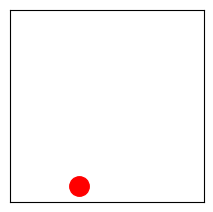

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 0, 0]]


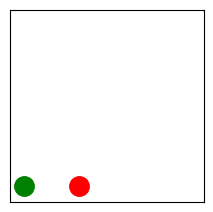

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [1, 0, 2, 0, 0, 0, 0]]


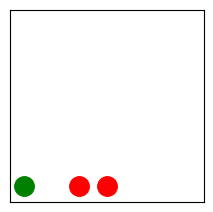

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [1, 0, 2, 2, 0, 0, 0]]


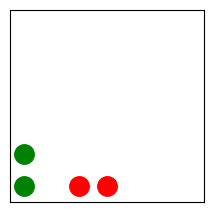

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 2, 2, 0, 0, 0]]


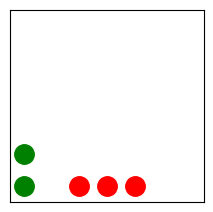

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 2, 2, 2, 0, 0]]


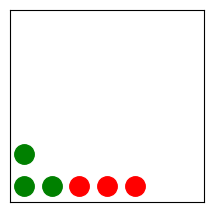

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 1, 2, 2, 2, 0, 0]]


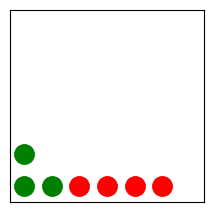

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 1, 2, 2, 2, 2, 0]]


In [45]:
for winner, start_player, moves_made in games:
    if winner == 2:
        print(start_player, "started")
        playback_game(moves_made, start_player,plot_game=True, print_game=True)
        inp = input("Press enter to continue, type 'q' to quit")
        if inp == "q":
            break

In [ ]:
ulrik_bots = [treebeard, gotcha, cat, gravity]